Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
files_small = {}
temp_list = !ls notMNIST_small
list_folders_small = [s for s in temp_list if "pickle" not in s]
#display(list_folders_small)
for letter in list_folders_small:
    temp_list = !ls notMNIST_small/$letter
    for i in xrange(0,len(temp_list)):
        temp_list[i] = "notMNIST_small/"+letter+"/"+temp_list[i]
    files_small[letter] = temp_list

files_large = {}
temp_list = !ls notMNIST_large
list_folders_large = [s for s in temp_list if "pickle" not in s]
#display(list_folders_large)
for letter in list_folders_large:
    temp_list = !ls notMNIST_large/$letter
    for i in xrange(0,len(temp_list)):
        temp_list[i] = "notMNIST_large/"+letter+"/"+temp_list[i]
    files_large[letter] = temp_list

In [5]:
import random
random_selection_images = []
for key in files_small.keys():
    random_selection_images.append(random.choice(files_small[key]))
for key in files_large.keys():
    random_selection_images.append(random.choice(files_large[key]))
random_selection_images

['notMNIST_small/A/QXZhbnRHYXJkZUlUQ2J5QlQtQm9va09ibGlxdWUub3Rm.png',
 'notMNIST_small/C/Q2FwaXRhbHMudHRm.png',
 'notMNIST_small/B/QW50aXF1ZU9saVQtQm9sZENvbmRJbjEub3Rm.png',
 'notMNIST_small/E/RFRMVmFuZGVuS2VlcmVEQ2Fwcy1Cb2xkLm90Zg==.png',
 'notMNIST_small/D/RnJ1dGlnZXJOZXh0TFQtTGlnaHQub3Rm.png',
 'notMNIST_small/G/QXVndXN0YVNjaG51cmtsU3RkLVJlZy5vdGY=.png',
 'notMNIST_small/F/QnVyYmFua0JpZ1JlZ3VsYXItQmxhY2sub3Rm.png',
 'notMNIST_small/I/Q29uY29yZGVCRS1Cb2xkQ24ub3Rm.png',
 'notMNIST_small/H/Qmlqb3V4LUJvbGQub3Rm.png',
 'notMNIST_small/J/Q2xhc3NpY2EgT25lLnR0Zg==.png',
 'notMNIST_large/A/RnV0dXJhQlEtRXh0cmFCb2xkLm90Zg==.png',
 'notMNIST_large/C/U2FuZG92YWwudHRm.png',
 'notMNIST_large/B/RHJlYW0gb2YgbWUudHRm.png',
 'notMNIST_large/E/U2NyaXB0b3JpYSBTbWFsbCBDYXBzIFNTaS50dGY=.png',
 'notMNIST_large/D/R291ZHktTWVkaWV2YWwudHRm.png',
 'notMNIST_large/G/UG9wcGwtTGF1ZGF0aW8gTWVkaXVtLnR0Zg==.png',
 'notMNIST_large/F/R291ZHkgUmV0cm9zcGVjdGl2ZSBTU2kudHRm.png',
 'notMNIST_large/I/U2FjY3VsZS50dGY=.png',


In [6]:
from IPython.display import Image, display

for imageName in random_selection_images:
    display(Image(filename=imageName))

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [7]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000, force=True)
test_datasets = maybe_pickle(test_folders, 1800, force=True)

Pickling notMNIST_large/A.pickle.
notMNIST_large/A
Could not read:

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.fp.read(1))
  File "//anaconda/lib/python2.7/site-packages/PIL/_binary.py", li

 notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read:

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.fp.read(1))
  File "//anaconda/lib/python2.7/site-packages/PIL/_binary.py", li

 notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Full dataset tensor: (52924, 28, 28)
Mean: -0.128248
Standard deviation: 0.443123
Pickling notMNIST_large/B.pickle.
notMNIST_large/B

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.fp.read(1))
  File "//anaconda/lib/python2.7/site-packages/PIL/_binary.py", li


Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52926, 28, 28)
Mean: -0.00756075
Standard deviation: 0.454492
Pickling notMNIST_large/C.pickle.
notMNIST_large/C
Full dataset tensor: (52925, 28, 28)
Mean: -0.14223
Standard deviation: 0.439815
Pickling notMNIST_large/D.pickle.
notMNIST_large/D

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.fp.read(1))
  File "//anaconda/lib/python2.7/site-packages/PIL/_binary.py", li


Could not read: notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png : cannot identify image file 'notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png' - it's ok, skipping.
Full dataset tensor: (52927, 28, 28)
Mean: -0.0573645
Standard deviation: 0.455647
Pickling notMNIST_large/E.pickle.
notMNIST_large/E
Full dataset tensor: (52924, 28, 28)
Mean: -0.069908
Standard deviation: 0.452941
Pickling notMNIST_large/F.pickle.
notMNIST_large/F
Full dataset tensor: (52933, 28, 28)
Mean: -0.125593
Standard deviation: 0.447085
Pickling notMNIST_large/G.pickle.
notMNIST_large/G
Full dataset tensor: (52930, 28, 28)
Mean: -0.0945837
Standard deviation: 0.44624
Pickling notMNIST_large/H.pickle.
notMNIST_large/H
Full dataset tensor: (52935, 28, 28)
Mean: -0.0685125
Standard deviation: 0.454231
Pickling notMNIST_large/I.pickle.
notMNIST_large/I
Full dataset tensor: (52930, 28, 28)
Mean: 0.0307791
Standard deviation: 0.468899
Pickling notMNIST_large/J.pickle.
notMNIST_large/J
Full dataset tensor: (52912, 28, 28)
Me

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.fp.read(1))
  File "//anaconda/lib/python2.7/site-packages/PIL/_binary.py", li


notMNIST_small/A
Could not read: notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png : cannot identify image file 'notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png' - it's ok, skipping.
Full dataset tensor: (1872, 28, 28)
Mean: -0.132626
Standard deviation: 0.445128
Pickling notMNIST_small/B.pickle.
notMNIST_small/B
Full dataset tensor: (1873, 28, 28)
Mean: 0.00535609
Standard deviation: 0.457115
Pickling notMNIST_small/C.pickle.
notMNIST_small/C
Full dataset tensor: (1873, 28, 28)
Mean: -0.141521
Standard deviation: 0.44269
Pickling notMNIST_small/D.pickle.
notMNIST_small/D
Full dataset tensor: (1874, 28, 28)
Mean: -0.0490702
Standard deviation: 0.459776
Pickling notMNIST_small/E.pickle.
notMNIST_small/E
Full dataset tensor: (1873, 28, 28)
Mean: -0.0599148
Standard deviation: 0.45735
Pickling notMNIST_small/F.pickle.
notMNIST_small/F

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.fp.read(1))
  File "//anaconda/lib/python2.7/site-packages/PIL/_binary.py", li


Could not read: notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png : cannot identify image file 'notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png' - it's ok, skipping.
Full dataset tensor: (1874, 28, 28)
Mean: -0.11809
Standard deviation: 0.452315
Pickling notMNIST_small/G.pickle.
notMNIST_small/G
Full dataset tensor: (1872, 28, 28)
Mean: -0.0925503
Standard deviation: 0.449006
Pickling notMNIST_small/H.pickle.
notMNIST_small/H
Full dataset tensor: (1872, 28, 28)
Mean: -0.0586893
Standard deviation: 0.458759
Pickling notMNIST_small/I.pickle.
notMNIST_small/I
Full dataset tensor: (1872, 28, 28)
Mean: 0.0526451
Standard deviation: 0.471894
Pickling notMNIST_small/J.pickle.
notMNIST_small/J
Full dataset tensor: (1872, 28, 28)
Mean: -0.151689
Standard deviation: 0.448014


---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [8]:
display(train_datasets)
display(test_datasets)

display(train_folders)
display(test_folders)

['notMNIST_large/A.pickle',
 'notMNIST_large/B.pickle',
 'notMNIST_large/C.pickle',
 'notMNIST_large/D.pickle',
 'notMNIST_large/E.pickle',
 'notMNIST_large/F.pickle',
 'notMNIST_large/G.pickle',
 'notMNIST_large/H.pickle',
 'notMNIST_large/I.pickle',
 'notMNIST_large/J.pickle']

['notMNIST_small/A.pickle',
 'notMNIST_small/B.pickle',
 'notMNIST_small/C.pickle',
 'notMNIST_small/D.pickle',
 'notMNIST_small/E.pickle',
 'notMNIST_small/F.pickle',
 'notMNIST_small/G.pickle',
 'notMNIST_small/H.pickle',
 'notMNIST_small/I.pickle',
 'notMNIST_small/J.pickle']

['notMNIST_large/A',
 'notMNIST_large/B',
 'notMNIST_large/C',
 'notMNIST_large/D',
 'notMNIST_large/E',
 'notMNIST_large/F',
 'notMNIST_large/G',
 'notMNIST_large/H',
 'notMNIST_large/I',
 'notMNIST_large/J']

['notMNIST_small/A',
 'notMNIST_small/B',
 'notMNIST_small/C',
 'notMNIST_small/D',
 'notMNIST_small/E',
 'notMNIST_small/F',
 'notMNIST_small/G',
 'notMNIST_small/H',
 'notMNIST_small/I',
 'notMNIST_small/J']

In [9]:
train_dataset = []
train_labels = []
for train_folder in train_folders:
    train_labels.append(train_folder.replace("notMNIST_large/", ""))
    train_dataset.append(load_letter(train_folder,10))
test_dataset = []
test_labels = []
for test_folder in test_folders:
    test_labels.append(test_folder.replace("notMNIST_small/", ""))
    test_dataset.append(load_letter(test_folder,10))

notMNIST_large/A
Could not read:

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.fp.read(1))
  File "//anaconda/lib/python2.7/site-packages/PIL/_binary.py", li

 notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read:

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.fp.read(1))
  File "//anaconda/lib/python2.7/site-packages/PIL/_binary.py", li

 notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Full dataset tensor: (52924, 28, 28)
Mean: -0.128248
Standard deviation: 0.443123
notMNIST_large/B

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.fp.read(1))
  File "//anaconda/lib/python2.7/site-packages/PIL/_binary.py", li


Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52926, 28, 28)
Mean: -0.00756075
Standard deviation: 0.454492
notMNIST_large/C
Full dataset tensor: (52925, 28, 28)
Mean: -0.14223
Standard deviation: 0.439815
notMNIST_large/D

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.fp.read(1))
  File "//anaconda/lib/python2.7/site-packages/PIL/_binary.py", li


Could not read: notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png : cannot identify image file 'notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png' - it's ok, skipping.
Full dataset tensor: (52927, 28, 28)
Mean: -0.0573645
Standard deviation: 0.455647
notMNIST_large/E
Full dataset tensor: (52924, 28, 28)
Mean: -0.069908
Standard deviation: 0.452941
notMNIST_large/F
Full dataset tensor: (52933, 28, 28)
Mean: -0.125593
Standard deviation: 0.447085
notMNIST_large/G
Full dataset tensor: (52930, 28, 28)
Mean: -0.0945837
Standard deviation: 0.44624
notMNIST_large/H
Full dataset tensor: (52935, 28, 28)
Mean: -0.0685125
Standard deviation: 0.454231
notMNIST_large/I
Full dataset tensor: (52930, 28, 28)
Mean: 0.0307791
Standard deviation: 0.468899
notMNIST_large/J
Full dataset tensor: (52912, 28, 28)
Mean: -0.153358
Standard deviation: 0.443657
notMNIST_small/A

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.fp.read(1))
  File "//anaconda/lib/python2.7/site-packages/PIL/_binary.py", li


Could not read: notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png : cannot identify image file 'notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png' - it's ok, skipping.
Full dataset tensor: (1872, 28, 28)
Mean: -0.132626
Standard deviation: 0.445128
notMNIST_small/B
Full dataset tensor: (1873, 28, 28)
Mean: 0.00535609
Standard deviation: 0.457115
notMNIST_small/C
Full dataset tensor: (1873, 28, 28)
Mean: -0.141521
Standard deviation: 0.44269
notMNIST_small/D
Full dataset tensor: (1874, 28, 28)
Mean: -0.0490702
Standard deviation: 0.459776
notMNIST_small/E
Full dataset tensor: (1873, 28, 28)
Mean: -0.0599148
Standard deviation: 0.45735
notMNIST_small/F

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "//anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.fp.read(1))
  File "//anaconda/lib/python2.7/site-packages/PIL/_binary.py", li


Could not read: notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png : cannot identify image file 'notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png' - it's ok, skipping.
Full dataset tensor: (1874, 28, 28)
Mean: -0.11809
Standard deviation: 0.452315
notMNIST_small/G
Full dataset tensor: (1872, 28, 28)
Mean: -0.0925503
Standard deviation: 0.449006
notMNIST_small/H
Full dataset tensor: (1872, 28, 28)
Mean: -0.0586893
Standard deviation: 0.458759
notMNIST_small/I
Full dataset tensor: (1872, 28, 28)
Mean: 0.0526451
Standard deviation: 0.471894
notMNIST_small/J
Full dataset tensor: (1872, 28, 28)
Mean: -0.151689
Standard deviation: 0.448014


//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


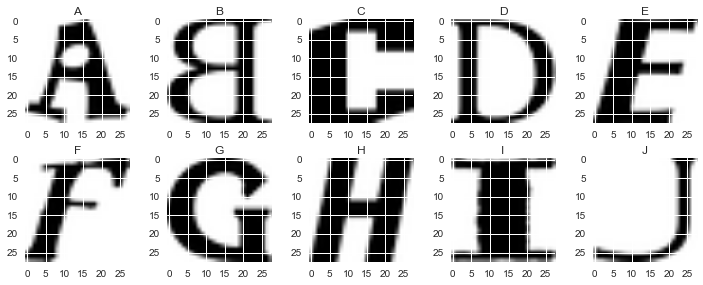

In [10]:
%matplotlib inline
from random import randint
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(10,4))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1)
    plt.imshow(train_dataset[i][randint(0,len(train_dataset[i]))])
    ax.set_title(train_labels[i])
plt.tight_layout()
fig = plt.gcf()

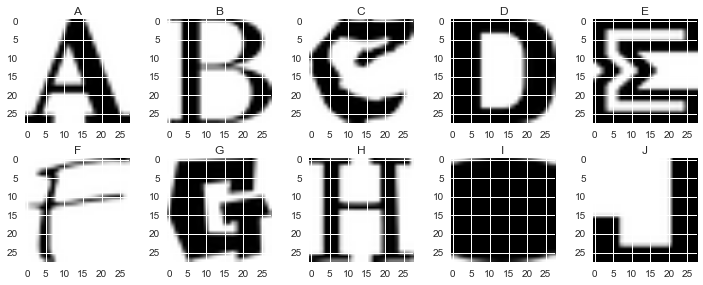

In [11]:
fig = plt.figure(figsize=(10,4))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1)
    plt.imshow(test_dataset[i][randint(0,len(test_dataset[i]))])
    ax.set_title(test_labels[i])
plt.tight_layout()
fig = plt.gcf()

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [12]:
for dataset in train_dataset:
    display(len(dataset))
for dataset in test_dataset:
    display(len(dataset))

52924

52926

52925

52927

52924

52933

52930

52935

52930

52912

1872

1873

1873

1874

1873

1874

1872

1872

1872

1872

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [13]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels


train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [14]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

train_dataset: mean = -0.0813681 std dev = 0.454308
test_dataset: mean = -0.0740373 std dev = 0.458822
valid_dataset: mean = -0.0795578 std dev = 0.454631

 65 66 67 68 69 70 71 72 73 74 



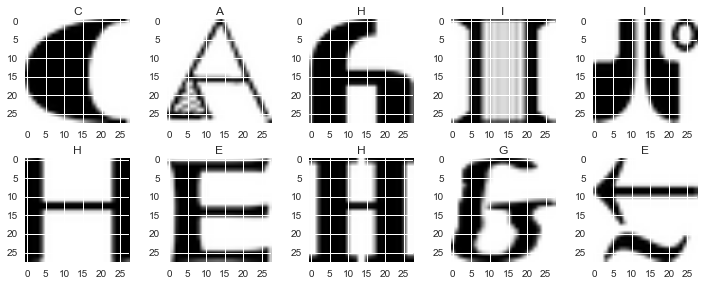

In [15]:
print ("train_dataset: mean =", np.mean(train_dataset), "std dev =", np.std(train_dataset))
print ("test_dataset: mean =", np.mean(test_dataset), "std dev =", np.std(test_dataset))
print ("valid_dataset: mean =", np.mean(valid_dataset), "std dev =", np.std(valid_dataset))

train_sample_indices = np.random.choice(200000, 10)
test_sample_indices = np.random.choice(10000, 10)

print('\n',ord('A'),ord('B'),ord('C'),ord('D'),ord('E'),ord('F'),ord('G'),ord('H'),ord('I'),ord('J'),'\n')

fig = plt.figure(figsize=(10,4))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1)
    plt.imshow(train_dataset[train_sample_indices[i]])
    ax.set_title(str(unichr(train_labels[train_sample_indices[i]]+65)))
plt.tight_layout()
fig = plt.gcf()

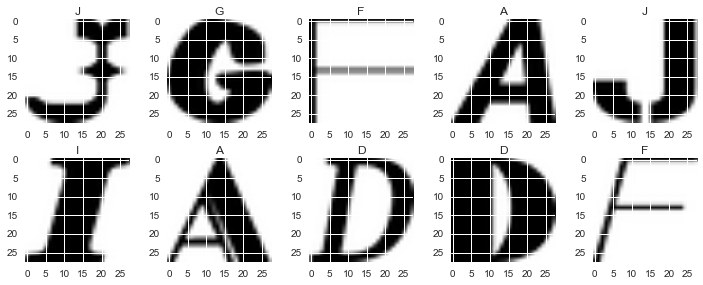

In [16]:
fig = plt.figure(figsize=(10,4))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1)
    plt.imshow(test_dataset[test_sample_indices[i]])
    ax.set_title(str(unichr(test_labels[test_sample_indices[i]]+65)))
plt.tight_layout()
fig = plt.gcf()

Finally, let's save the data for later reuse:

In [17]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [18]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [36]:
# dataset sizes to start
print("train -> total train samples:", len(train_labels))
print("valid -> total valid samples:", len(valid_labels))
print("test  -> total test samples: ",  len(test_labels))

train -> total train samples: 200000
valid -> total valid samples: 10000
test  -> total test samples:  10000


In [19]:
import time

def find_duplicates(dataset):
    duplicate_indices = []
    dataset_size = len(dataset)
    for i in xrange(dataset_size):
        if i not in duplicate_indices:
            for j in xrange(i+1,dataset_size):
                if j not in duplicate_indices:
                    if np.array_equal(dataset[i], dataset[j]):
                        duplicate_indices.append(j)
    return duplicate_indices

t1 = time.time()
valid_duplicates = find_duplicates(valid_dataset)
t2 = time.time()
print("number duplicates in valid =", len(valid_duplicates))
print("time taken =", t2-t1, "seconds")

1946.3332209587097

143

This is very slow. Let's compare hashes instead to start and find how many duplicates there are.

In [20]:
import hashlib

t1 = time.time()

# set of string
train_hashes = set([hashlib.sha1(x).digest() for x in train_dataset])
valid_hashes = set([hashlib.sha1(x).digest() for x in valid_dataset])
test_hashes  = set([hashlib.sha1(x).digest() for x in test_dataset])

# how many duplicates in each dataset are there?
print("number train_duplicates = ", len(train_dataset) - len(train_hashes))
print("number test_duplicates = ", len(test_dataset) - len(test_hashes))
print("number valid_duplicates = ", len(valid_dataset) - len(valid_hashes))

t2 = time.time()

print("")
print("time taken =", t2-t1, "seconds")

number train_duplicates =  12602
number test_duplicates =  209
number valid_duplicates =  143
time taken = 10.6793589592 seconds


In [37]:
t1 = time.time()

# list of string
train_hashes = [hashlib.sha1(x).digest() for x in train_dataset]
valid_hashes = [hashlib.sha1(x).digest() for x in valid_dataset]
test_hashes  = [hashlib.sha1(x).digest() for x in test_dataset]

# boolean arrays showing the train datapoint hashes which are also in the valid and test hashes
valid_in_train = np.in1d(valid_hashes, train_hashes)
test_in_train  = np.in1d(test_hashes,  train_hashes)
test_in_valid  = np.in1d(test_hashes,  valid_hashes)

print("valid -> train overlap: %d samples" % valid_in_train.sum())
print("test  -> train overlap: %d samples" % test_in_train.sum())
print("test  -> valid overlap: %d samples" % test_in_valid.sum())
print("")

# the complementary arrays
valid_keep = ~valid_in_train
test_keep  = ~(test_in_train | test_in_valid)

valid_overlap = valid_in_train.sum()
test_overlap = (test_in_train | test_in_valid).sum()

t2 = time.time()
print("Time to find overlap: %0.2fs" % (t2 - t1))

valid -> train overlap: 1049 samples
test  -> train overlap: 1285 samples
test  -> valid overlap: 205 samples

Time to find overlap: 8.14s


In [38]:
t1 = time.time()

# Make clean datasets
valid_dataset_clean = valid_dataset[valid_keep]
valid_labels_clean  = valid_labels [valid_keep]
test_dataset_clean = test_dataset[test_keep]
test_labels_clean  = test_labels [test_keep]

print("valid -> total images removed:", len(valid_hashes)-len(valid_labels_clean))
print("test  -> total images removed:",  len(test_hashes)-len(test_labels_clean))
print("")
print("valid -> remaining valid samples:", len(valid_labels_clean))
print("test  -> remaining test samples: ",  len(test_labels_clean))
print("")

t2 = time.time()
print("Time to clean valid and test datasets: %0.2fs" % (t2 - t1))

valid -> total images removed: 1049
test  -> total images removed: 1328

valid -> remaining valid samples: 8951
test  -> remaining test samples:  8672

Time to clean valid and test datasets: 0.08s


In [22]:
# remove duplicates also
def remove_duplicate_hashes(list_hashes, list_bool_keep):
    if len(list_hashes) != len(list_bool_keep):
        print("remove_duplicate_hashes: lists should the same length")
    for index in xrange(len(list_hashes)):
        if list_hashes[index] in list_hashes[:index]:
            list_bool_keep[index] = False

In [29]:
# test function remove_duplicate_hashes(list_hashes, list_bool_keep)
x = np.array([0, 1, 2, 1, 4, 1, 6, 1, 2, 1])
y = np.ones((len(x),), dtype=np.bool)
remove_duplicate_hashes(x,y)
display(x)
display(y)

array([0, 1, 2, 1, 4, 1, 6, 1, 2, 1])

array([ True,  True,  True, False,  True, False,  True, False, False, False], dtype=bool)

In [42]:
train_keep = np.ones((len(train_hashes),), dtype=np.bool)

t1 = time.time()

remove_duplicate_hashes(train_hashes, train_keep)
remove_duplicate_hashes(valid_hashes, valid_keep)
remove_duplicate_hashes(test_hashes, test_keep)

t2 = time.time()
print("Time to find duplicates: %0.2fs" % (t2 - t1))

Time to find duplicates: 1074.17s


In [43]:
t1 = time.time()

# Make clean datasets
train_dataset_clean = train_dataset[train_keep]
train_labels_clean  = train_labels [train_keep]
valid_dataset_clean = valid_dataset[valid_keep]
valid_labels_clean  = valid_labels [valid_keep]
test_dataset_clean = test_dataset[test_keep]
test_labels_clean  = test_labels [test_keep]

print("train -> total duplicates removed:", len(train_hashes)-len(train_labels_clean))
print("valid -> total duplicates removed:", len(valid_hashes)-len(valid_labels_clean)-valid_overlap)
print("test  -> total duplicates removed:",  len(test_hashes)-len(test_labels_clean)-test_overlap)
print("")

print("train -> remaining train samples:", len(train_labels_clean))
print("valid -> remaining valid samples:", len(valid_labels_clean))
print("test  -> remaining test samples: ",  len(test_labels_clean))
print("")

t2 = time.time()
print("Time to make clean datasets: %0.2fs" % (t2 - t1))

train -> total duplicates removed: 12602
valid -> total duplicates removed: 24
test  -> total duplicates removed: 49

train -> remaining train samples: 187398
valid -> remaining valid samples: 8927
test  -> remaining test samples:  8623

Time to make clean datasets: 3.25s


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [39]:
# Reshape our data so we can use SKLearn

n_samples = [50, 100, 1000, 2500, 5000, 10000]
n_samples_max = n_samples[-1]
n_features = train_dataset.shape[1] * train_dataset.shape[2]

X_train_clean = np.reshape(train_dataset_clean[:n_samples_max], (n_samples_max,            n_features) )
X_valid       = np.reshape(valid_dataset                      , (len(valid_dataset),       n_features) )
X_valid_clean = np.reshape(valid_dataset_clean                , (len(valid_dataset_clean), n_features) )
X_test        = np.reshape( test_dataset                      , (len(test_dataset),        n_features) )
X_test_clean  = np.reshape( test_dataset_clean                , (len(test_dataset_clean),  n_features) )

In [40]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score

logistic_classifier = linear_model.LogisticRegression()

acc_train = []
acc_valid = []
acc_valid_clean = []
acc_test = []
acc_test_clean = []

for n in n_samples:
    
    logistic_classifier.fit(X_train_clean[:n], train_labels_clean[:n])
    
    y_pred = logistic_classifier.predict(X_train_clean[:n])
    acc_train.append(accuracy_score(y_pred, train_labels_clean[:n]))

    y_pred = logistic_classifier.predict(X_valid)
    acc_valid.append(accuracy_score(y_pred, valid_labels))

    y_pred = logistic_classifier.predict(X_valid_clean)
    acc_valid_clean.append(accuracy_score(y_pred, valid_labels_clean))

    y_pred  = logistic_classifier.predict(X_test)
    acc_test.append(accuracy_score(y_pred, test_labels))

    y_pred  = logistic_classifier.predict(X_test_clean)
    acc_test_clean.append(accuracy_score(y_pred, test_labels_clean))

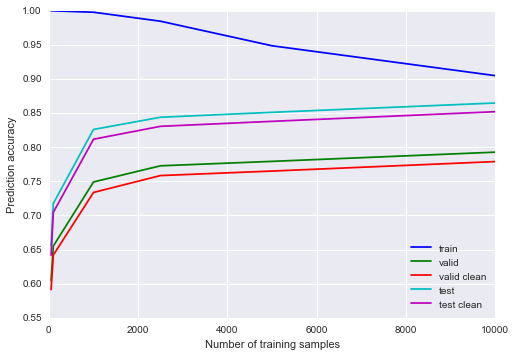

In [46]:
import pylab

pylab.plot(n_samples, acc_train,       'b', label='train')
pylab.plot(n_samples, acc_valid,       'g', label='valid')
pylab.plot(n_samples, acc_valid_clean, 'r', label='valid clean')
pylab.plot(n_samples, acc_test,        'c', label='test')
pylab.plot(n_samples, acc_test_clean,  'm', label='test clean')
pylab.xlabel('Number of training samples')
pylab.ylabel('Prediction accuracy')
pylab.legend(loc='lower right')
pylab.show()